In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'g'

In [2]:
PATH_FOLDER = './data'
DATA_FILE = 'avocado.csv'

# EDA_FOLDER = './eda'
# EDA_FILE = 'avocado_eda.html'

DATA_DIR = os.path.join(PATH_FOLDER, DATA_FILE)
# EDA_DIR = os.path.join(EDA_FOLDER, EDA_FILE)

In [3]:
df = pd.read_csv(DATA_DIR, index_col=0)
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11


# EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18249 entries, 0 to 11
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
 13  month         18249 non-null  int32         
dtypes: datetime64[ns](1), float64(9), int32(1), int64(1), object(2)
memory usage: 2.0+ MB


In [5]:
df.describe()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,month
count,18249,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000
mean,2016-08-13 23:30:43.498273792,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899,6.177215
min,2015-01-04 00:00:00,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000,1.000000
25%,2015-10-25 00:00:00,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000,3.000000
50%,2016-08-14 00:00:00,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000,6.000000
75%,2017-06-04 00:00:00,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000,9.000000
max,2018-03-25 00:00:00,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000,12.000000
std,NaN,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938,3.534130


In [6]:
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
month           0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe(include='O')

,type,region
count,18249,18249
unique,2,54
top,conventional,Albany
freq,9126,338


In [9]:
df.groupby(['year', 'type']).agg({'Date': 'count'})

Date
year type              
2015 conventional  2808
     organic       2807
2016 conventional  2808
     organic       2808
2017 conventional  2862
     organic       2860
2018 conventional   648
     organic        648

In [10]:
df.groupby('year')['AveragePrice'].mean()

year
2015    1.375590
2016    1.338640
2017    1.515128
2018    1.347531
Name: AveragePrice, dtype: float64

<Axes: xlabel='month', ylabel='AveragePrice'>

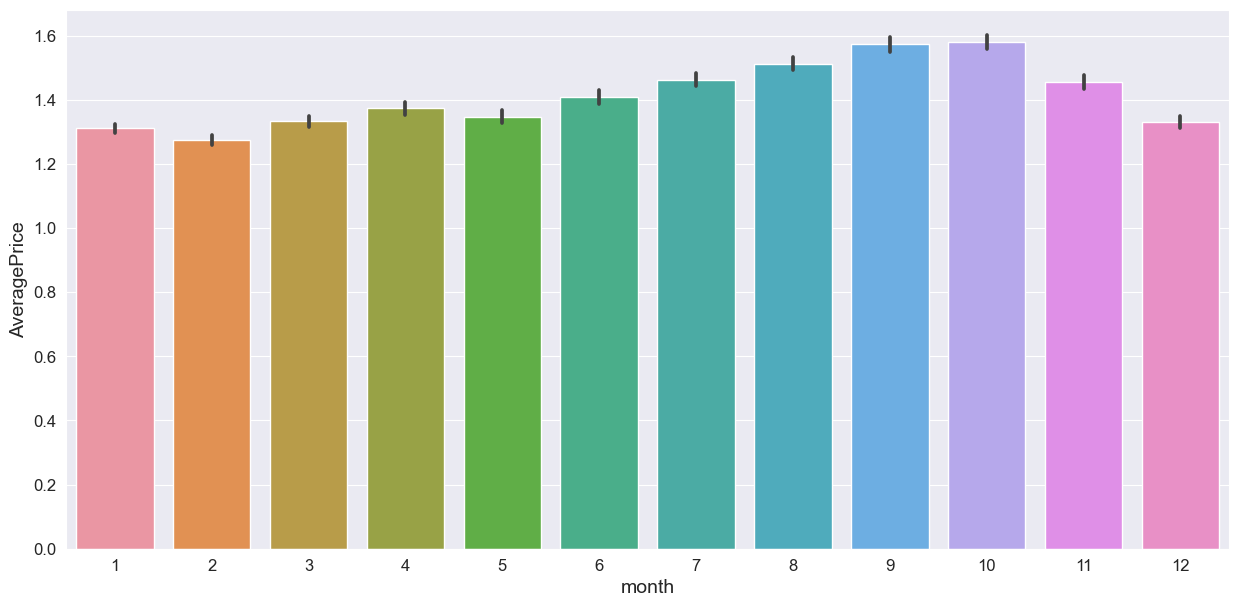

In [11]:
sns.barplot(x='month', y='AveragePrice', data=df)

<Axes: xlabel='month', ylabel='AveragePrice'>

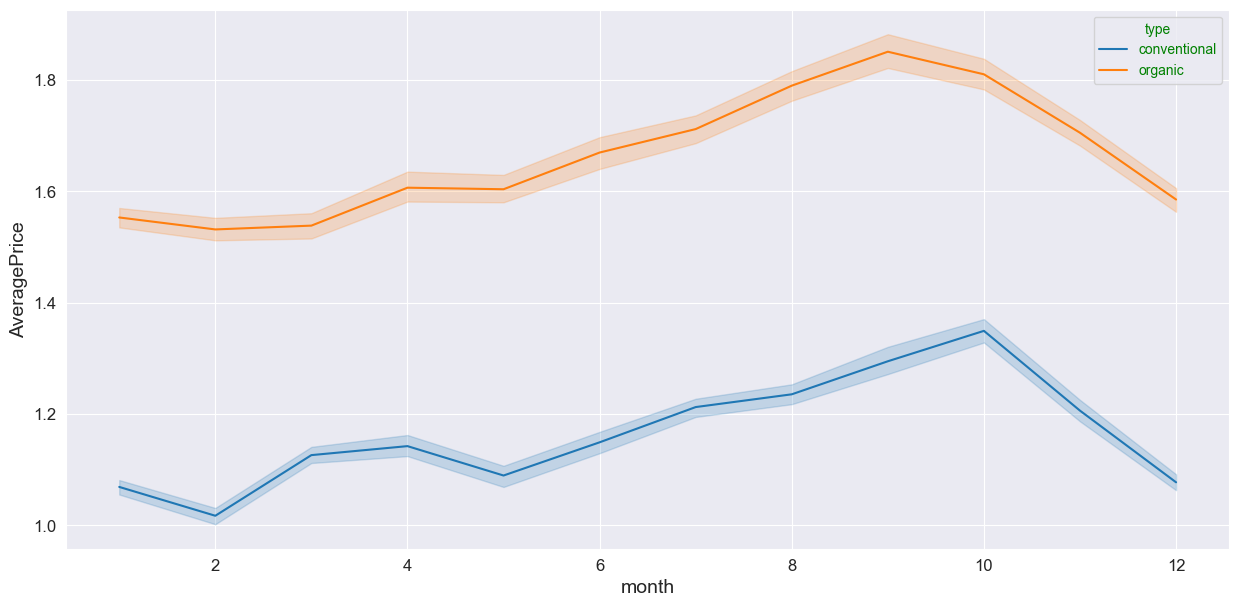

In [12]:
sns.lineplot(x='month', y='AveragePrice', hue='type', data=df)

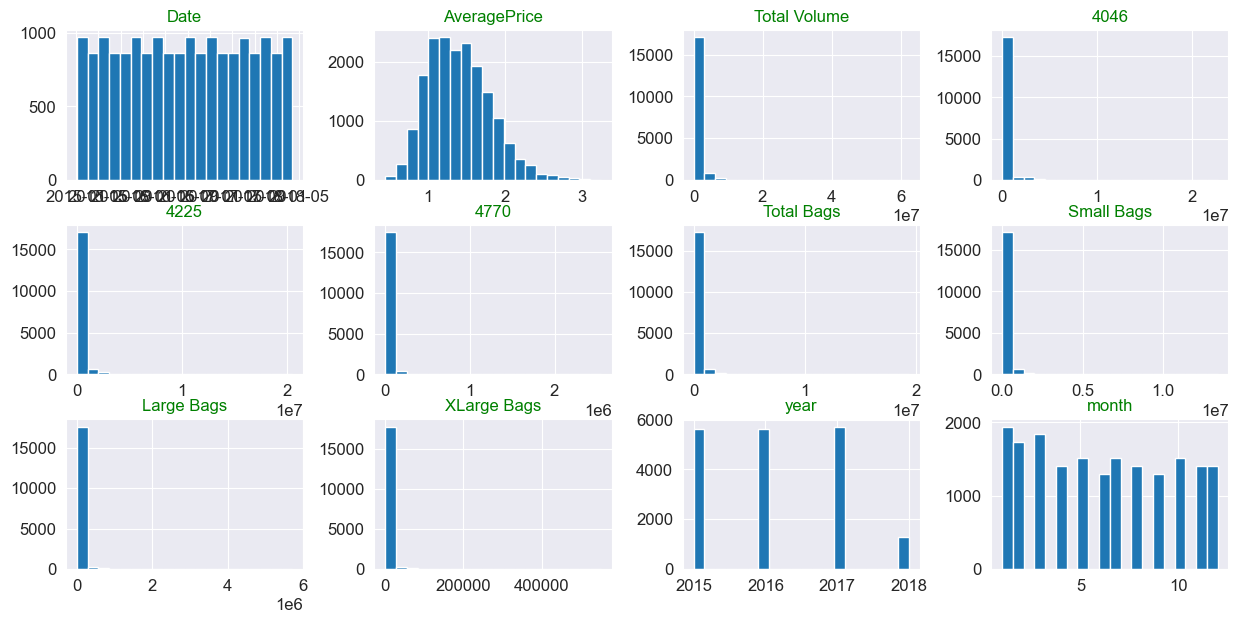

In [13]:
df.hist(bins=20, layout=(3, 4))
plt.show()

In [14]:
skew_cols = ['Total Volume', '4046', '4225', '4770', 'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags']

df_skewness = df[skew_cols].skew()

for col in skew_cols:
    if df_skewness.loc[col]>0.55:
        df[col] = np.log1p(df[col])

In [15]:
corr = df[['AveragePrice'] + skew_cols+['year', 'month']].corr()
corr

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year,month
AveragePrice,1.000000,-0.583411,-0.543861,-0.446584,-0.507234,-0.574931,-0.493520,-0.478741,-0.379680,0.093197,0.162409
Total Volume,-0.583411,1.000000,0.886538,0.908610,0.834274,0.934924,0.876670,0.671429,0.661647,0.086274,-0.034262
4046,-0.543861,0.886538,1.000000,0.761893,0.747167,0.785653,0.741634,0.582992,0.585774,0.011078,-0.033224
4225,-0.446584,0.908610,0.761893,1.000000,0.794104,0.790640,0.722492,0.614586,0.589352,0.014321,-0.030705
4770,-0.507234,0.834274,0.747167,0.794104,1.000000,0.773176,0.747692,0.558938,0.643214,-0.040618,-0.025808
Total Bags,-0.574931,0.934924,0.785653,0.790640,0.773176,1.000000,0.929040,0.709648,0.633930,0.222446,-0.022617
Small Bags,-0.493520,0.876670,0.741634,0.722492,0.747692,0.929040,1.000000,0.526174,0.599928,0.202987,-0.017234
Large Bags,-0.478741,0.671429,0.582992,0.614586,0.558938,0.709648,0.526174,1.000000,0.469564,0.193857,-0.020540
XLarge Bags,-0.379680,0.661647,0.585774,0.589352,0.643214,0.633930,0.599928,0.469564,1.000000,0.168146,0.001257
year,0.093197,0.086274,0.011078,0.014321,-0.040618,0.222446,0.202987,0.193857,0.168146,1.000000,-0.177050


# Future Engineering

In [16]:
data = df.copy()

In [17]:
data['season'] = data['month'] % 12 // 3 + 1

## Train - Test Split

In [18]:
target_var = ['AveragePrice']
cols_to_remove = ['AveragePrice','Date','4046','4225','4770','Small Bags','Large Bags','XLarge Bags']
num_cols = ['Total Volume', 'Total Bags', 'year', 'month', 'season']
cat_cols = ['type','region']

In [19]:
y = data[target_var].values
data.drop(cols_to_remove, axis=1, inplace=True)

In [20]:
df_train, df_test, y_train, y_test = train_test_split(data, y.ravel(), test_size = 0.2, random_state = 13)
df_train.shape, df_test.shape, y_train.shape, y_test.shape

((14599, 7), (3650, 7), (14599,), (3650,))

In [21]:
np.mean(y_train), np.mean(y_test)

(1.4056291526816904, 1.4073753424657534)

## Columns Encoding

### Type

In [22]:
le = LabelEncoder()
# Label encoding of Type variable
df_train['type_cat'] = le.fit_transform(df_train['type'])
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
df_test['type_cat'] = le.transform(df_test['type'])
df_test['type_cat'].fillna(-1, inplace=True)
# Drop the type column
df_train.drop(['type'], axis = 1, inplace=True)
df_test.drop(['type'], axis = 1, inplace=True)

### Region

In [23]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
# One hot encoding of Region variable
enc_train = ohe.fit_transform(df_train[['region']])
enc_test = ohe.transform(df_test[['region']])
# OHE name mapping
ohe_name_mapping = dict(zip(ohe.categories_[0], np.arange(0, len(ohe.categories_[0]))))
cols = ['region_' + str(x) for x in ohe_name_mapping.keys()]
# Create a dataframe with OHE data
ohe_data_train = pd.DataFrame(enc_train.toarray(), columns=cols)
ohe_data_test = pd.DataFrame(enc_test.toarray(), columns=cols)
# Concatenate the OHE data with the original dataframe
df_train = pd.concat([df_train.reset_index(drop=True), ohe_data_train.reset_index(drop=True)], axis=1)
df_test = pd.concat([df_test.reset_index(drop=True), ohe_data_test.reset_index(drop=True)], axis=1)
# Drop the region column
df_train.drop(['region'], axis = 1, inplace=True)
df_test.drop(['region'], axis = 1, inplace=True)

# Models

## UDFs

In [24]:
def run_model(model, df_train, y_train, df_test):
    pipe = Pipeline([('scaler', StandardScaler()), ('lr', model)])
    pipe.fit(df_train, y_train)
    y_pred = pipe.predict(df_test)
    return y_pred

def model_evaluation(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("R2: {:.2f}".format(r2))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("MAPE: {:.2f}%".format(mape))
    return r2, mae, rmse, mape

In [25]:
y_pred = run_model(LinearRegression(), df_train, y_train, df_test)
r2, mae, rmse, mape = model_evaluation(y_test, y_pred)

R2: 0.72
MAE: 0.16
RMSE: 0.21
MAPE: 11.52%


In [26]:
y_pred = run_model(RandomForestRegressor(), df_train, y_train, df_test)
r2, mae, rmse, mape = model_evaluation(y_test, y_pred)

R2: 0.91
MAE: 0.08
RMSE: 0.12
MAPE: 6.23%


In [27]:
y_pred = run_model(XGBRegressor(), df_train, y_train, df_test)
r2, mae, rmse, mape = model_evaluation(y_test, y_pred)

R2: 0.90
MAE: 0.09
RMSE: 0.13
MAPE: 6.83%


## Hyperparameter Tuning

### XGBRegressor

In [28]:
def objective_xgb(trial):
    """Define the objective function"""
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }
    # Train test split
    df_train_op, df_val, y_train_op, y_val = train_test_split(df_train, y_train, test_size=0.2, random_state=13)    
    # Fit the model
    optuna_model = XGBRegressor(**params, n_jobs=-1, verbosity=0)
    optuna_model.fit(df_train_op, y_train_op)
    # Make predictions
    y_pred = optuna_model.predict(df_val)
    # Evaluate predictions
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return rmse

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective_xgb, n_trials=200, show_progress_bar=True)
trial = study.best_trial

[I 2024-02-22 21:02:34,455] A new study created in memory with name: no-name-38e1fc0f-330b-4c2a-92f9-a4d201c24351


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-02-22 21:02:34,675] Trial 0 finished with value: 0.23625501356583062 and parameters: {'learning_rate': 0.07204658408741424, 'gamma': 0.33319995412442277, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.22250417433108965, 'colsample_bytree': 0.5826227338535324, 'reg_alpha': 0.00013061910812185726, 'reg_lambda': 4.759619131624791e-05, 'n_estimators': 484}. Best is trial 0 with value: 0.23625501356583062.
[I 2024-02-22 21:02:34,857] Trial 1 finished with value: 0.358240212141724 and parameters: {'learning_rate': 0.01186289596163493, 'gamma': 0.000363199480964593, 'max_depth': 1, 'min_child_weight': 3, 'subsample': 0.30644396243365196, 'colsample_bytree': 0.025880472906296328, 'reg_alpha': 0.00025134594870285156, 'reg_lambda': 0.4902472543763754, 'n_estimators': 495}. Best is trial 0 with value: 0.23625501356583062.
[I 2024-02-22 21:02:34,971] Trial 2 finished with value: 0.16025694208992552 and parameters: {'learning_rate': 0.2810587423291974, 'gamma': 9.040110678787295e-08,

### Best Model

In [30]:
reg = XGBRegressor(**trial.params)
reg.fit(df_train, y_train)
y_pred = reg.predict(df_test)
r2, mae, rmse, mape = model_evaluation(y_test, y_pred)

R2: 0.93
MAE: 0.08
RMSE: 0.11
MAPE: 5.56%


In [37]:
dt = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
with open(f'./model/xgb_model_{dt}.pkl', 'wb') as f:
    pickle.dump(reg, f)

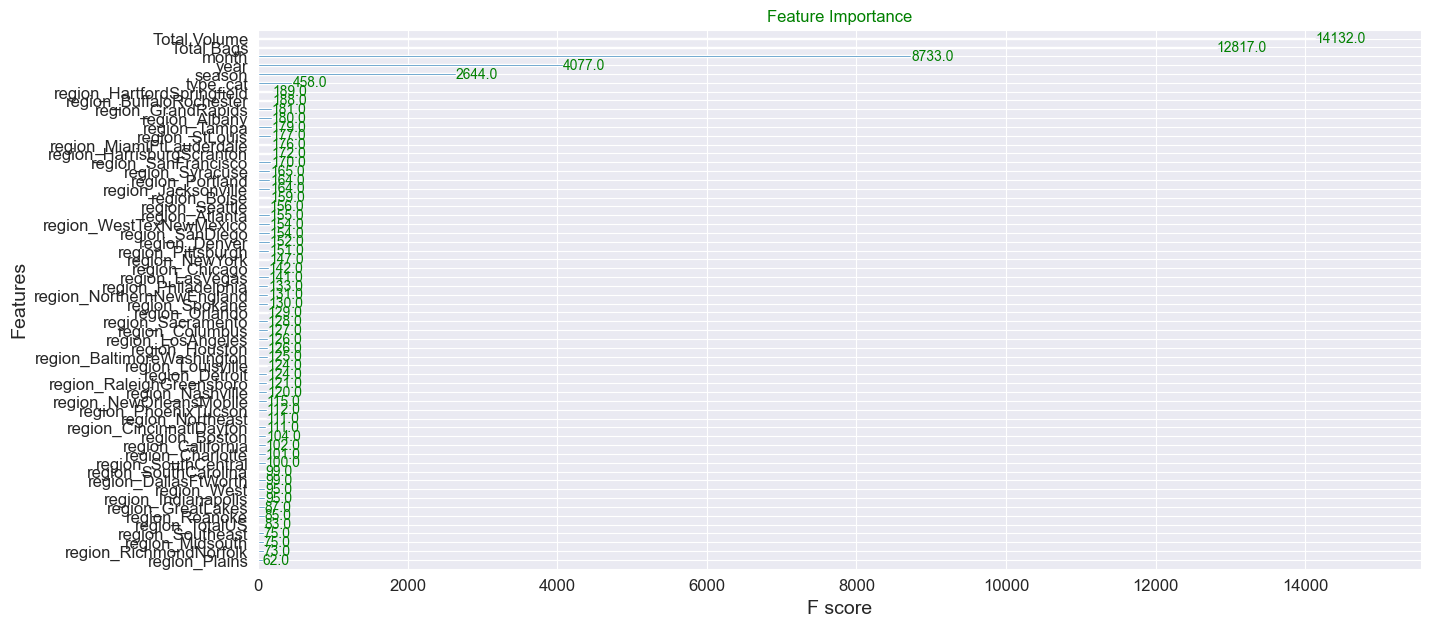

In [32]:
plot_importance(reg)
plt.title("Feature Importance")
plt.show()

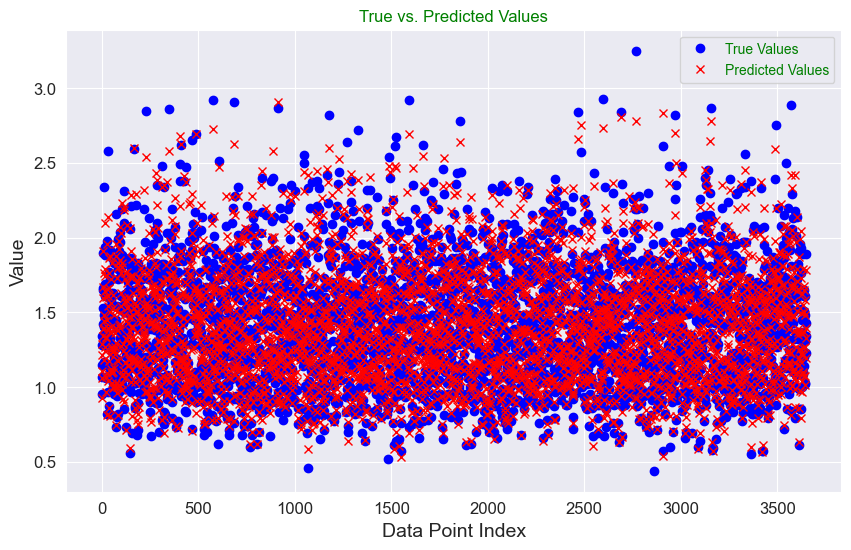

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values', color='blue', linestyle='None', marker='o')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='None', marker='x')
plt.title("True vs. Predicted Values")
plt.xlabel("Data Point Index")
plt.ylabel("Value")
plt.legend()
plt.show()

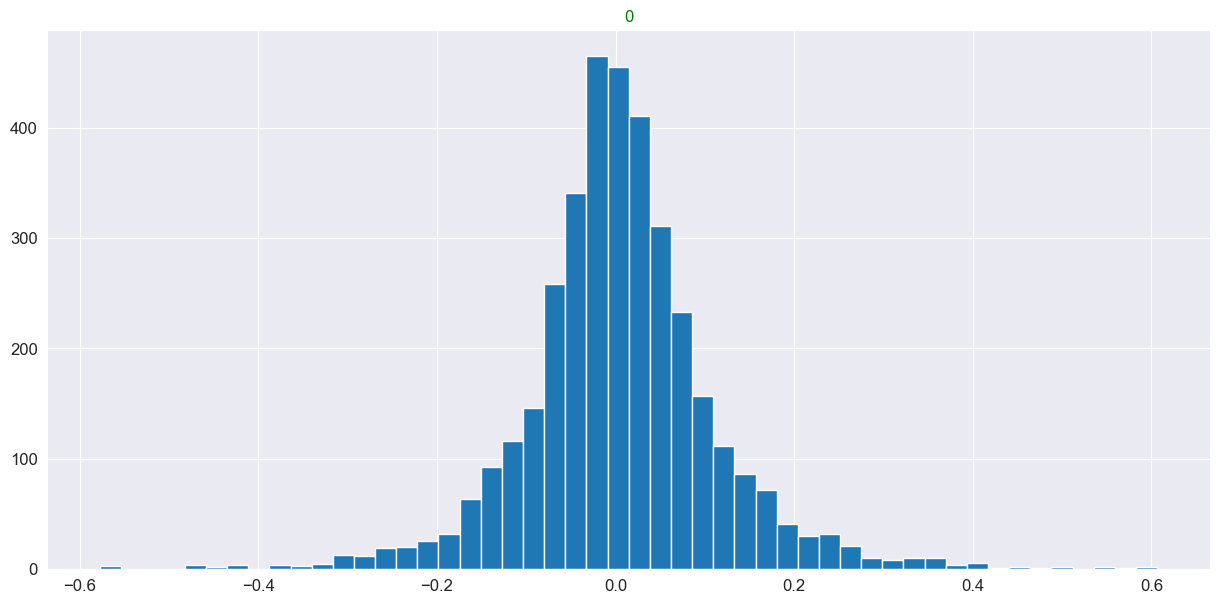

In [39]:
pd.DataFrame(y_pred-y_test).hist(bins=50)
plt.show()

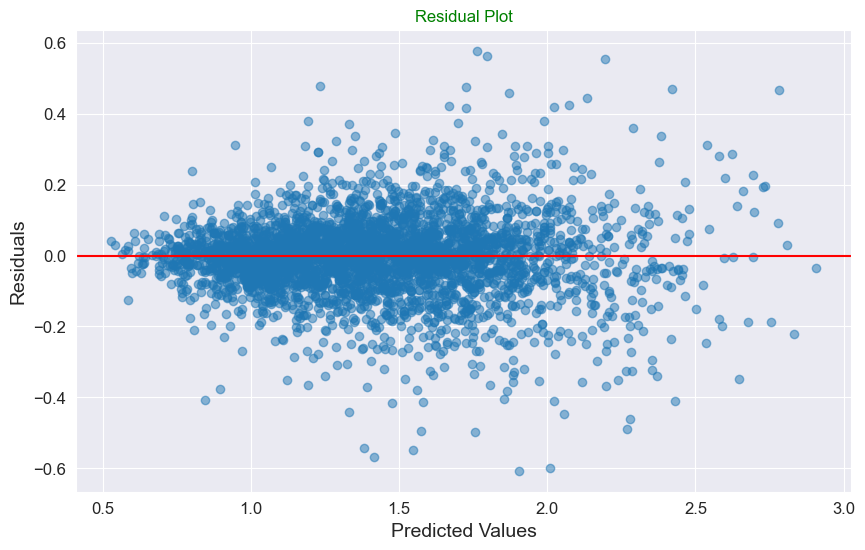

In [35]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title("Residual Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

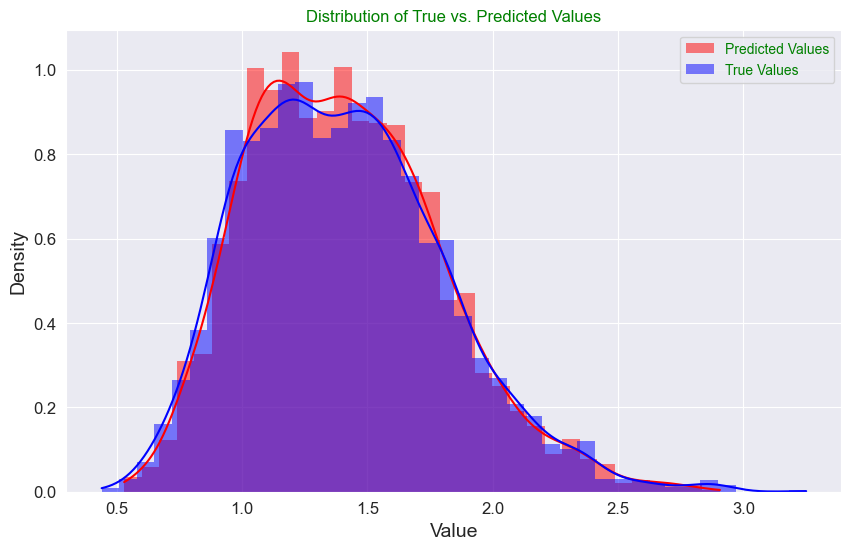

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, color="red", label="Predicted Values", kde=True, stat="density", linewidth=0)
sns.histplot(y_test, color="blue", label="True Values", kde=True, stat="density", linewidth=0)
plt.title("Distribution of True vs. Predicted Values")
plt.xlabel("Value")
plt.legend()
plt.show()